# LSTM model
from https://github.com/Xinyi6/DP-LSTM-Differential-Privacy-inspired-LSTM-for-Stock-Prediction-Using-Financial-News and make some changes

### Where we can use big compute:
- Adding noises to data
- The computations of multi-sequence predictions
- The calculation of MSE

### Where we cannot use big compute:
- The training of LSTM


In [1]:
from google.colab import drive
drive.mount('/content/drive')
G_PATH = './drive/MyDrive/Colab Notebooks/Drug Binding'

%cd ./drive/My Drive/Colab Notebooks/cs205/Parallel-LSTM/model/long_1

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs205/Parallel-LSTM/model/long_1


In [56]:
! git add .
! git commit -m 'after colab'
! git push


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@d7a561194925.(none)')
fatal: could not read Username for 'https://github.com': No such device or address


## COG Model

In [1]:
import json
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import keras
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

import matplotlib.pyplot as plt
import pickle

stock = 'COG'
industry = 'energy'

In [2]:
# read data
data = pd.read_csv('../../data/processed_data/data/processed_data_' + industry + '_mega_15.csv')
data.head(5)

,window,NewsScore,StockPrice_COG,StockPrice_DVN,StockPrice_HFC
0,"Row(start=datetime.datetime(2009, 1, 1, 0, 0),...","[0.8906000000000001, 0.8906000000000001, 0.544...",NaN,NaN,NaN
1,"Row(start=datetime.datetime(2009, 1, 2, 0, 0),...","[0.5442, 0.5441999999999999, 0.0, 0.0, 0.7089,...","[0.32653055724814845, 0.5086341199773035, 0.50...","[0.5272333991371081, 0.7124182970322922, 0.709...","[0.0, 0.0895196188301123, 0.08165934336398818,..."
2,"Row(start=datetime.datetime(2009, 1, 3, 0, 0),...","[0.0, 0.0, 0.7089, 0.7089, 0.29486666666666667...","[0.5058083698758729, 0.5029826197744417, 0.500...","[0.7156184148392801, 0.7129155107768615, 0.710...","[0.033103501497158766, 0.02482762612286887, 0...."
3,"Row(start=datetime.datetime(2009, 1, 4, 0, 0),...","[0.7089, 0.7089, 0.29486666666666667, 0.294866...","[0.5001568696730111, 0.49733111957158, 0.49450...","[0.7160412620933285, 0.7133927230470116, 0.710...","[0.01655175074857979, 0.008275875374289894, 0...."
4,"Row(start=datetime.datetime(2009, 1, 5, 0, 0),...","[0.29486666666666667, 0.29486666666666667, 0.0...","[0.4945053694701494, 0.7990580034523904, 1.0, ...","[0.7164474348066494, 0.8995611887558574, 1.0, ...","[0.0, 0.358620535434369, 0.544827731355888, 0...."


In [3]:
data.iloc[-2:]

,window,NewsScore,StockPrice_COG,StockPrice_DVN,StockPrice_HFC
4473,"Row(start=datetime.datetime(2021, 4, 1, 0, 0),...","[0.6960999999999999, 0.899, 0.7917761904761904...","[0.9240505310394724, 1.0, 0.9867390454821439, ...","[0.2707181854681067, 1.0, 0.9928965920171047, ...","[0.4204543607294307, 1.0, 0.9963473968797198, ..."
4474,"Row(start=datetime.datetime(2021, 4, 2, 0, 0),...","[0.7917761904761904, 0.8606666666666667, 0.740...","[1.0, 0.9874214268577276, 0.9748428537154566, ...","[1.0, 0.9928457726212289, 0.9856915452424597, ...","[1.0, 0.9963340064602798, 0.9926680129205576, ..."


In [4]:
# data = data.iloc[:-1]
# ratio of train and test data 0.8:0.2
train_len = int(len(data)*0.9)
test_len = len(data) - train_len

### 2. Processing data

In [5]:
def str2num(row):
    l = row.split(',')
    result = []
    result.append(float(l[0][1:]))
    for n in l[1:-1]:
        result.append(float(n))
    result.append(float(l[-1][:-1]))
    return result

In [6]:
df_prices_train = list(data['StockPrice_' + stock.upper()][:train_len])
df_prices_test = list(data['StockPrice_' + stock.upper()][train_len:])
df_senti_train = list(data['NewsScore'][:train_len])
df_senti_test = list(data['NewsScore'][train_len:])


In [7]:
len(df_senti_train[0].split(','))

30

In [8]:
# prepare train and test data
def input_data(df_prices, df_senti):
    x = []
    y = []
    min_max = []
    for i, row in enumerate(df_prices):
        if type(row) == float:
            continue
        prices = str2num(row)
        senti = str2num(df_senti[i])
        one_row = []
        for i, p in enumerate(prices[:21]):
            one_row.append([p, senti[i]])
        x.append(one_row)
        y.append(prices[21])
        min_max.append(prices[-2:])
    x = np.array(x)
    y = np.array(y)
    return x, y, min_max

In [9]:
x_train, y_train, min_max_train = input_data(df_prices_train, df_senti_train)
x_test, y_test, min_max_test = input_data(df_prices_test, df_senti_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4026, 21, 2) (4026,) (448, 21, 2) (448,)


In [17]:
# model parameters setting
normalise= True  # normalize 3 features
batch_size=64;
input_dim=x_train.shape[2]  # ['price','sentiment']
input_timesteps=x_train.shape[1] # the window length of a training data set
neurons=10  # number of neurons in one LSTM layer
epochs=50
dense_output=1  # output size of the last dense layer
drop_out=0.1  # dropout rate

In [14]:
# Build LSTM MODEL
def lstm():
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
    model.add(Dropout(drop_out))
    model.add(LSTM(neurons,return_sequences = True))
    model.add(LSTM(neurons,return_sequences =False))
    model.add(Dropout(drop_out))
    model.add(Dense(dense_output, activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error',
                    optimizer='adam')
    # Fit the model
    model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)
    return model

## Train models 10 times and get the mean prediction

In [11]:
models = []
predictions = []
rmses = []
times = 10
for i in range(times):
    model = lstm()
    models.append(model)
    prediction_seqs = model.predict(x_test).reshape(-1,)
    predictions.append(prediction_seqs)
    rmse = np.sqrt(mean_squared_error(prediction_seqs, y_test))
    rmses.append(rmse)


Epoch 1/50
23/23 [==============================] - 6s 27ms/step - loss: 0.3067
Epoch 2/50
23/23 [==============================] - 1s 25ms/step - loss: 0.1429
Epoch 3/50
23/23 [==============================] - 1s 25ms/step - loss: 0.1316
Epoch 4/50
23/23 [==============================] - 1s 24ms/step - loss: 0.1326
Epoch 5/50
23/23 [==============================] - 1s 25ms/step - loss: 0.1203
Epoch 6/50
23/23 [==============================] - 1s 25ms/step - loss: 0.1040
Epoch 7/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0977
Epoch 8/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0951
Epoch 9/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0941
Epoch 10/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0861
Epoch 11/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0897
Epoch 12/50
23/23 [==============================] - 1s 24ms/step - loss: 0.0882
Epoch 13/50
23/23 [==================

In [13]:
for i, m in enumerate(models):
  m.save('lstm_cog_small_short_saved/lstm_energy_long1_{}.h5'.format(i))

In [ ]:
model = keras.models.load_model('lstm_energy_long1.h5')

In [14]:
means = []
stds1 = []
for r in np.array(predictions).T:
    means.append(r.mean())
    stds1.append(np.std(r))


In [15]:
np.array(predictions).T.shape

(367, 10)

In [16]:
y1 = np.array([x - y for x, y in zip(means, stds1)])
y2 = np.array([sum(x) for x in zip(means, stds1)])
np.array(means).shape

(367,)

## 1 Model training

In [18]:
model = lstm()

Epoch 1/50
56/56 [==============================] - 6s 21ms/step - loss: 0.2017
Epoch 2/50
56/56 [==============================] - 1s 19ms/step - loss: 0.1018
Epoch 3/50
56/56 [==============================] - 1s 23ms/step - loss: 0.0866
Epoch 4/50
56/56 [==============================] - 1s 18ms/step - loss: 0.0824
Epoch 5/50
56/56 [==============================] - 1s 19ms/step - loss: 0.0823
Epoch 6/50
56/56 [==============================] - 1s 26ms/step - loss: 0.0775
Epoch 7/50
56/56 [==============================] - 2s 28ms/step - loss: 0.0775
Epoch 8/50
56/56 [==============================] - 1s 26ms/step - loss: 0.0807
Epoch 9/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0714
Epoch 10/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0704
Epoch 11/50
56/56 [==============================] - 1s 25ms/step - loss: 0.0637
Epoch 12/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0606
Epoch 13/50
56/56 [==================

In [25]:
if os.path.exists('../model_saved/' + industry + '_' + stock + '_2009_1.h5'):
    os.remove('../model_saved/' + industry + '_' + stock + '_2009_1.h5')
else:
    # print("The saved model does not exist")
    model.save('../model_saved/' + industry + '_' + stock + '_2009_1.h5')

In [19]:
#multi sequence predict
prediction_seqs = model.predict(x_test).reshape(-1,) # prediction data
# !! parallelizable !!

'''
for x in x_test:
      temp=model.predict(curr_frame[newaxis,:,:])[0]
      predicted.append(temp)
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
'''

'\nfor x in x_test:\n      temp=model.predict(curr_frame[newaxis,:,:])[0]\n      predicted.append(temp)\n      curr_frame = curr_frame[1:]\n      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)\n    prediction_seqs.append(predicted)\n'

In [ ]:
np.sqrt(mean_squared_error(prediction_seqs, y_test))

0.2285751025223302

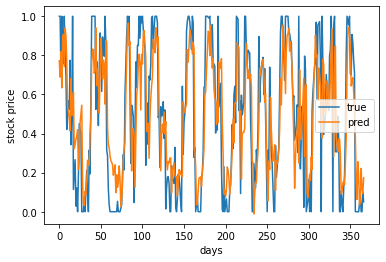

In [ ]:
plt.plot(y_test, label = 'true')
plt.plot(prediction_seqs, label = 'pred')
plt.xlabel('days')
plt.ylabel('stock price')
plt.legend()

### De-normalized


In [20]:
ori_price = pd.read_csv('../../data/stock_price/data/' + industry +'/price_' + stock.upper() + '.csv')
ori_price.head(5)

,Date,Type,ticker,Price
0,2016-03-31,Open,COG,22.740000
1,2016-03-31,Closed,COG,22.709999
2,2016-04-01,Open,COG,22.260000
3,2016-04-01,Closed,COG,22.510000
4,2016-04-04,Open,COG,22.610001


In [22]:
def normalize(x):
    """
    Normalize the input to the range between 0 and 1
    """
    x = np.array(x)
    x_normalized = ((x - np.min(x)) / (np.max(x) - np.min(x))).tolist()
    return x_normalized
max_price = np.max(ori_price['Price'])
min_price = np.min(ori_price['Price'])
def denorm(x, min_max):
    de_result = []
    for i, v in enumerate(x):
        min_p, max_p = min_max[i]
        v_denorm = v * (max_p - min_p) + min_p
        de_result.append(v_denorm)
    return de_result


In [23]:
# one model prediction
pred_denorm = denorm(prediction_seqs, min_max_test)
ytest_denorm = denorm(y_test, min_max_test)
print('Industry: ', industry, '; stock: ', stock.upper())
print('The max price is {0}, the min price is {1}'.format(max_price, min_price))
print('The RMSE of predictions is', np.sqrt(mean_squared_error(pred_denorm, ytest_denorm)))

Industry:  energy ; stock:  COG
The max price is 29.489999771118164, the min price is 13.09000015258789
The RMSE of predictions is 0.3834402336898678


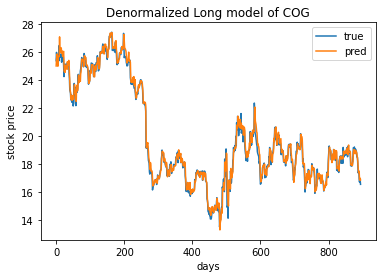

In [24]:
plt.plot(ytest_denorm, label = 'true')
plt.plot(pred_denorm, label = 'pred')
plt.xlabel('days')
plt.ylabel('stock price')
plt.title('Denormalized Long model of ' + stock)
plt.legend()

In [43]:
# 10 model predictions
pred_denorm = [denorm(x, min_max_test) for x in predictions]
means = []
stds1 = []
for r in np.array(pred_denorm).T:
    means.append(r.mean())
    stds1.append(np.std(r))
ytest_denorm = denorm(y_test, min_max_test)
print('Industry: ', industry, '; stock: ', stock.upper())
print('The max price is {0}, the min price is {1}'.format(max_price, min_price))
print('The RMSE of predictions is', np.sqrt(mean_squared_error(means, ytest_denorm)))

Industry:  energy ; stock:  COG
The max price is 29.489999771118164, the min price is 13.09000015258789
The RMSE of predictions is 0.3674875879971799


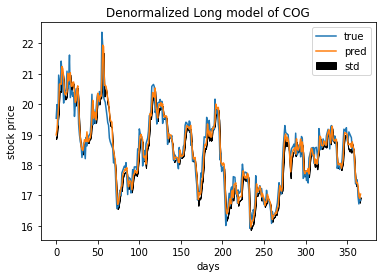

In [54]:
plt.plot(ytest_denorm, label = 'true')
plt.plot(means, label = 'pred')
plt.xlabel('days')
plt.ylabel('stock price')
plt.title('Denormalized Long model of ' + stock)

plt.fill_between(range(367), y1= np.array([x - 2*y for x, y in zip(means, stds1)]), y2 = np.array([x-2*y for x,y in zip(means, stds1)]), color = 'black', alpha = 1, label = 'std')
plt.legend()
plt.show()

In [53]:
stds1

[0.06467021895158506,
 0.07111766454996961,
 0.08499477620604413,
 0.10786010413070843,
 0.10602924834768546,
 0.09190395947758306,
 0.12026559691602849,
 0.10519692294115797,
 0.06320394433789506,
 0.061245439361835304,
 0.0593127875546015,
 0.07297845244296246,
 0.069082307492216,
 0.04801530446118317,
 0.0625806403911798,
 0.047330548488075976,
 0.037737528273147615,
 0.033827755229476675,
 0.06909140768184027,
 0.039205966440251164,
 0.031215457802105006,
 0.026526494512663194,
 0.048781771037016336,
 0.05661677176881605,
 0.0349713746365251,
 0.04771730591675532,
 0.03797027776276233,
 0.0505147643430317,
 0.05550975489262134,
 0.05195473247420178,
 0.05944742550233835,
 0.07222641265932078,
 0.06352095086748771,
 0.06016442719016004,
 0.06112186620001608,
 0.05409665537789511,
 0.058300897407603795,
 0.05043821318486272,
 0.023281439285657707,
 0.01947091327212276,
 0.011873210461612767,
 0.02144218962469927,
 0.032688099177085296,
 0.07290825742268264,
 0.06556996295461834,
 0.0

In [39]:
means[0] * (min_max_test[0][1] - min_max_test[0][0]) + min_max_test[0][0]

18.991644625423532

In [38]:
means[0]

0.7466007

In [41]:
min_max_test[0][1] - min_max_test[0][0]

2.164000701904296

In [42]:
min_max_test[0][0]

17.376000213623048